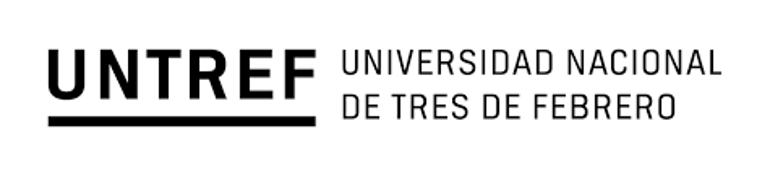

### Montar Google Drive

In [ ]:
from google.colab import drive

try:
    drive.mount('/content/drive')
except Exception as e:
    print(f"Ocurrió un error al montar Google Drive: {e}")

### Instalación de librerías necesarias

In [ ]:
%%capture
# Tensorboard
!pip install tensorboard
# Métricas objetivas
!pip install pesq pystoi --quiet
# PGHIPY
!pip install pghipy --quiet

Debug

In [ ]:
# Debugging
%pdb off

### Imports

In [ ]:
# Librerías basicas
import os
import random
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import time

# Audio y procesamiento de señales
#import torchaudio
#from torchaudio.transforms import Resample #, Spectrogram , GriffinLim
from pghipy import stft as stft_pghipy, pghi, istft as istft_pghipy, get_default_window, calculate_synthesis_window
import librosa as lib

# Métricas objetivas
from pesq import pesq, NoUtterancesError
from pystoi import stoi

# PyTorch
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# IPython para widget de audio
import IPython.display as ipd

# Progreso
from tqdm.auto import tqdm
from torch.utils.tensorboard import SummaryWriter

### Parameters

In [ ]:
# Directorios
BASE_DIR = '/content/drive/MyDrive/TESIS_2025'
DATASET_DIR = os.path.join(BASE_DIR, 'Dataset')
RESULTS_DIR = os.path.join(BASE_DIR, 'Results', 'R2AttPGHI')
TENSORBOARD_DIR = os.path.join(RESULTS_DIR, 'tensorboard')
CLEAN_WAV_DIR = os.path.join(DATASET_DIR, 'clean_trainset_28spk_wav')
NOISY_WAV_DIR = os.path.join(DATASET_DIR, 'noisy_trainset_28spk_wav')
CLEAN_WAV_TESTSET_DIR = os.path.join(DATASET_DIR, 'clean_testset_wav')
NOISY_WAV_TESTSET_DIR = os.path.join(DATASET_DIR, 'noisy_testset_wav')
CLEAN_STFT_DIR = os.path.join(DATASET_DIR, 'clean_stft_trainset_npz')
NOISY_STFT_DIR = os.path.join(DATASET_DIR, 'noisy_stft_trainset_npz')
LOG_FILE = os.path.join(DATASET_DIR, 'logfiles', 'log_trainset_28spk.txt')
STEP_FILE = os.path.join(RESULTS_DIR, 'save_step.pickle')
SUB_TESTSET_FILE = os.path.join(DATASET_DIR, 'test_samples_40.csv')
# Define la ruta del CSV en la carpeta RESULTS
PESQ_LOG_FILE = os.path.join(RESULTS_DIR, "pesq_log.csv")
BASIC_TESTS = False

# Configuración del dispositivo
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# Parámetros del DataLoader
BATCH_SIZE = 8
N_FFT = 512
HOP_LENGTH = N_FFT//8 # 64
SR = 16000  # Frecuencia de muestreo (Hz)
ORIGINAL_SR = 48000
DYNAMIC_RANGE_DB = 120

# Parámetros del Generador y Discriminador
INPUT_CHANNELS_GEN = 1
INPUT_CHANNELS_DISC = 2
OUTPUT_CHANNELS = 1
NDF = 16
LR_GEN = 0.0002
LR_DISC = 0.0001
MAX_MASK = 1.1

# Configuración del entrenamiento
EPOCHS = 100
# Repeticiones del generador por paso de entrenamiento en el discriminador.
GEN_REPEATS = 5
# Cada cuantos pasos se monitorea
MONITOR_STEP = 100
# Cada cuantos pasos se evalua
EVALUATION_STEP = 100
# Cada cuantos pasos se guarda el modelo
SAVE_STEP = 200

# Configuración de pérdidas y métricas
MAX_PESQ = 4.6
L1 = nn.L1Loss()
L2 = nn.MSELoss()

# Pesos de la pérdida del generador
LAMBDA_TF = 0.75       # TIEMPO-FRECUENCIA
LAMBDA_METRIC = 0.05  # ADV PESQ
LAMBDA_IRM = 0.1     # IRM
LAMBDA_TIME = 0.1    # TIEMPO

### Clases


#### VoiceFileManager

In [ ]:
class VoiceFileManager:
    """
    Se encarga de manejar las rutas a los archivos de audio
    de voz limpia y voz con ruido.
    """

    def __init__(self):
        """
        Inicializa las rutas base.
        Lee el archivo de logs del dataset.
        Lista los archivos de audio.
        """
        self.clean_wav_dir = CLEAN_WAV_DIR
        self.noisy_wav_dir = NOISY_WAV_DIR
        self.clean_testset_wav_dir = CLEAN_WAV_TESTSET_DIR
        self.noisy_testset_wav_dir = NOISY_WAV_TESTSET_DIR
        self.clean_npz_dir = CLEAN_STFT_DIR
        self.noisy_npz_dir = NOISY_STFT_DIR
        self.log = pd.read_csv(LOG_FILE)
        self.clean_files = os.listdir(self.clean_wav_dir)
        self.noisy_files = os.listdir(self.noisy_wav_dir)
        self.clean_testset_files = os.listdir(self.clean_testset_wav_dir)
        self.noisy_testset_files = os.listdir(self.noisy_testset_wav_dir)
        self._validate_files()
        self.current_filename = None

    def _validate_files(self) -> None:
        """
        Valida que la cantidad de archivos de audio limpio y ruidoso
        coincidan.
        """
        if len(self.clean_files) != len(self.noisy_files):
            raise ValueError("Clean and noisy files do not match in length.")

    def __len__(self) -> int:
        """
        Retorna la cantidad de archivos de audio.
        """
        return len(self.clean_files)

    def get_file_pair(self, idx: int, format: str = '.wav') -> tuple[str, str]:
        """
        Retorna el par de rutas para el audio limpio y ruidoso.

        -- Params --
        idx: int | indice del archivo.
        format: str | formato del archivo.

        -- Returns --
        clean_path: str | ruta del archivo limpio.
        noisy_path: str | ruta del archivo ruidoso.
        """
        # Retorna las rutas correspondientes al archivo limpio
        # y ruidoso en el índice idx
        clean_file = self.clean_files[idx]
        noisy_file = clean_file  # asumiendo que es el mismo nombre
        filename = clean_file.split('.')[0]
        # Sets current filename
        self.current_filename = filename
        if format == '.wav':
            clean_path = os.path.join(self.clean_wav_dir, clean_file)
            noisy_path = os.path.join(self.noisy_wav_dir, noisy_file)
        elif format == '.npz':
            filename_npz = filename + '.npz'
            clean_path = os.path.join(self.clean_npz_dir, filename_npz)
            noisy_path = os.path.join(self.noisy_npz_dir, filename_npz)
        return clean_path, noisy_path

    def get_testset_files(self) -> tuple[list[str], list[str]]:
        """
        Retorna las rutas de los archivos de audio de prueba
        limpios y ruidosos.
        """
        clean_file_paths = [
            os.path.join(self.clean_testset_wav_dir, filename)
            for filename in self.clean_testset_files
        ]
        noisy_file_paths = [
            os.path.join(self.noisy_testset_wav_dir, filename)
            for filename in self.clean_testset_files
        ]
        return clean_file_paths, noisy_file_paths

    def get_sub_testset_files(self, extension: str = ".wav") -> tuple[list[str], list[str]]:
        """
        Retorna las rutas de los archivos de un subconjunto (40)
        de los audios de prueba limpios y ruidosos.
        """
        # Leer el CSV
        df = pd.read_csv(SUB_TESTSET_FILE)
        # Construir la lista de archivos con ruta completa
        clean_file_paths = [
            os.path.join(self.clean_testset_wav_dir,
                         f"{row['file']}{extension}") for _, row in df.iterrows()
        ]
        noisy_file_paths = [
            os.path.join(self.noisy_testset_wav_dir,
                         f"{row['file']}{extension}") for _, row in df.iterrows()
        ]
        return clean_file_paths, noisy_file_paths

    def get_random_test_file(self) -> tuple[str,str,str]:
        """
        Selecciona un par aleatorio de voz limpia y con ruido
        del conjunto de test.
        Retorna las rutas de los archivos y el nombre del archivo.
        """
        clean_file = random.choice(self.clean_testset_files)
        noisy_file = clean_file
        clean_path = os.path.join(self.clean_testset_wav_dir, clean_file)
        noisy_path = os.path.join(self.noisy_testset_wav_dir, noisy_file)
        return clean_path, noisy_path, clean_file

In [ ]:
if BASIC_TESTS:
    # Instance UT
    vfm_ut = VoiceFileManager()
    # Run Methods
    clean_path_ut, noisy_path_ut = vfm_ut.get_file_pair(1)
    testset_files_ut = vfm_ut.get_testset_files()
    sub_testset_files_ut = vfm_ut.get_sub_testset_files()
    clean_random_path_ut, noisy_random_path_ut, file_ut = vfm_ut.get_random_test_file()
    # Basics Tests
    assert len(vfm_ut) == 11572
    assert len(testset_files_ut[0]) == 824
    assert len(sub_testset_files_ut[0]) == 40

#### AudioProcessor

In [ ]:
class AudioProcessor:
    """
    Carga y resamplea archivos de audio.
    Calcula la STFT usando PGHI.
    Adapta la STFT para el entrenamiento.
    """

    def __init__(self):
        """
        Inicializa el procesador de audio.
        Setea las ventanas para el calculo de la STFT utilizando PGHI.
        """
        self.dynamic_range_db = DYNAMIC_RANGE_DB
        # Gaussian windows
        self.window, self.gamma = get_default_window(N_FFT)
        self.synthesis_window = calculate_synthesis_window(N_FFT, HOP_LENGTH, self.window)
        # Sampling rate
        self.sr = SR


    def load_and_resample(self, audio_path: str) -> np.ndarray:
        """
        Carga un audio y lo remuestrea a SR.

        -- Params --
        audio_path: str | ruta del archivo de audio.

        -- Returns --
        resampled_audio: np.ndarray (n_samples,) | audio remuestreado.
        """
        resampled_audio, _ = lib.load(audio_path, sr=self.sr)
        return resampled_audio # (n_samples,)

    def stft(self, audio_np: np.ndarray, complex: bool = False) -> np.ndarray:
        """
        Calcula la STFT utilizando pghipy.

        -- Params --
        audio_np: np.ndarray (n_samples,) | audio.

        -- Returns --
        stft_matrix: np.ndarray (f,t) | STFT magnitude.
        """
        if not isinstance(audio_np, np.ndarray):
            raise TypeError("input must be a numpy array")
        stft_matrix = stft_pghipy(audio_np,win_length=N_FFT,hop_length=HOP_LENGTH,window=self.window)
        if complex:
            return stft_matrix.T # transpose to (f,t)
        return np.abs(stft_matrix).T # transpose to (f,t)

    def istft(self, mag_stft_np: np.ndarray, original_len: int = None) -> np.ndarray:
        """
        Invierte la STFT utilizando pghipy.

        -- Params --
        mag_stft_np: np.ndarray (f,t) | STFT magnitude.
        original_len: int | longitud del audio original.

        -- Returns --
        audio: np.ndarray (n_samples,) | audio.
        """
        # Check type
        if not isinstance(mag_stft_np, np.ndarray):
            raise TypeError("input must be a numpy array")
        # Recovers [t,f] for inversion
        mag_stft_np = np.abs(mag_stft_np).T
        # Checks proper dimensions for inversion
        try:
            t,f = mag_stft_np.shape
        except ValueError:
            raise ValueError(f"Se esperaba un np.ndarray 2D, no {mag_stft_np.shape}")
        if f != (N_FFT//2)+1:
            raise ValueError(f"Se esperaba shape[1]=={(N_FFT//2)+1}, no {mag_stft_np.shape}")
        # Estimate phase using PGHI
        phase_stft = pghi(mag_stft_np,win_length=N_FFT,hop_length=HOP_LENGTH,gamma=self.gamma)
        # complex stft for inversion
        stft_complex = mag_stft_np*np.exp(1.0j*phase_stft)
        audio = istft_pghipy(stft_complex, win_length=N_FFT, hop_length=HOP_LENGTH, synthesis_window=self.synthesis_window)
        if original_len is not None:
            audio = audio[:original_len]
        return audio # (n_samples,)

    def adapt_stft(self, mag_stft_tensor: torch.Tensor) -> tuple[torch.Tensor, float]:
        '''
        1 - Divide por el maximo. Rango=[0;1] sin compresion
        2 - Limita el valor minimo a 10^(-DR/20)
        3 - Convierte y comprime a escala logaritmica. Rango=[-DR;0]
        4 - Divide por DR. Rango=[-1;0]
        5 - Suma 1. Rango=[0;1]


        -- Params --
        mag_stft_tensor: torch.Tensor | STFT magnitude.

        -- Returns --
        adapted_stft: torch.Tensor | STFT magnitude.
        max_amp: float | valor maximo de la STFT por el que se normalizo
        '''
        # Normalize by max
        mag_stft_tensor = torch.abs(mag_stft_tensor)
        max_amp = float(torch.max(mag_stft_tensor))
        mag_stft_tensor = mag_stft_tensor / max_amp
        # Clamp min amplitude to 10**(-DR/20)
        min_amplitude = 10**(-self.dynamic_range_db/20)
        mag_stft_tensor = torch.clamp(mag_stft_tensor, min=min_amplitude) # [1e(-DR/20);1]
        # To log scale
        mag_stft_tensor = 20*torch.log10(mag_stft_tensor) # [-DR;0]
        # To [-1;0]
        mag_stft_tensor = mag_stft_tensor/(self.dynamic_range_db)
        # To [0;1]
        mag_stft_tensor = mag_stft_tensor + 1.0
        return mag_stft_tensor, max_amp

    def deadapt_stft(self, adapted_stft: torch.Tensor, max_amp:float = 1.0) -> torch.Tensor:
        '''
        Revierte lo realizado en adapt_stft
        Si no se provee max_amp devuelve la stft normalizada [0;1]

        -- Params --
        adapted_stft: torch.Tensor | adapted STFT magnitude.
        max_amp: float | valor maximo de la STFT por el que se normalizo (si se conserva)

        -- Returns --
        stft_mag: torch.Tensor | STFT magnitude. En rango original o [0;1]
        '''
        # To [-1;0]
        stft_mag = adapted_stft - 1.0
        # To [-DR;0]
        stft_mag_db = stft_mag * self.dynamic_range_db
        # To [1e(-DR/20);1]
        stft_mag = torch.pow(10.0, stft_mag_db / 20.0)
        # To original max amp
        stft_mag = stft_mag * max_amp
        return stft_mag

In [ ]:
if BASIC_TESTS:
    # Instance UT
    ap_ut = AudioProcessor()
    # Run Methods
    # Clean and noisy audios UT
    clean_audio_ut = ap_ut.load_and_resample(clean_random_path_ut)
    noisy_audio_ut = ap_ut.load_and_resample(noisy_random_path_ut)
    # Clean and noisy STFTs
    clean_stft_ut = ap_ut.stft(clean_audio_ut)
    noisy_stft_ut = ap_ut.stft(noisy_audio_ut)
    # ISTFTs audios
    clean_i_audio_ut = ap_ut.istft(clean_stft_ut, original_len=len(clean_audio_ut))
    noisy_i_audio_ut = ap_ut.istft(noisy_stft_ut, original_len=len(noisy_audio_ut))
    # To Tensor
    clean_stft_ut_t = torch.from_numpy(clean_stft_ut).float()
    noisy_stft_ut_t = torch.from_numpy(noisy_stft_ut).float()
    # Adapted STFTs
    adapted_clean_stft_ut, max_clean_amp = ap_ut.adapt_stft(clean_stft_ut_t)
    adapted_noisy_stft_ut, max_noisy_amp = ap_ut.adapt_stft(noisy_stft_ut_t)
    # Deadapted STFTs
    deadapted_clean_stft_ut = ap_ut.deadapt_stft(adapted_clean_stft_ut, max_amp=max_clean_amp)
    deadapted_noisy_stft_ut = ap_ut.deadapt_stft(adapted_noisy_stft_ut, max_amp=max_noisy_amp)
    # Basics Tests
    assert isinstance(clean_audio_ut, np.ndarray)
    assert clean_stft_ut.shape[0] == (N_FFT//2)+1
    assert len(clean_i_audio_ut) == len(clean_audio_ut)
    assert adapted_clean_stft_ut.size() == deadapted_clean_stft_ut.size() == clean_stft_ut_t.size()
    assert adapted_clean_stft_ut.max() == 1
    assert adapted_clean_stft_ut.min() == 0
    assert deadapted_clean_stft_ut.max() == clean_stft_ut_t.max()
    assert deadapted_clean_stft_ut.min() >= 10**(-DYNAMIC_RANGE_DB/20)

#### MetricComputer

In [ ]:
class MetricComputer:
    """
    Calcula métricas de evaluación objetiva.
    """

    def __init__(self, pesq_mode: str = 'wb',
                 stoi_extended: bool = False,
                 decimals: int = 3):
        """
        Inicializa el objeto encargado de computar las metricas objetivas.

        -- Params --
        pesq_mode: str | 'wb' para narrowband o 'nb' para wideband.
        stoi_extended: bool | True para usar la versión extendida de stoi.
        decimals: int | cantidad de decimales para redondear los resultados.
        """
        self.sr = SR
        self.pesq_mode = pesq_mode
        self.stoi_extended = stoi_extended
        self.decimals = decimals

    def check_input(self, input, tipo) -> None:
        """
        Comprueba que el input sea del tipo especificado.
        Comprueba que tenga shape: (n_samples,).
        Si no lo es levanta un TypeError.
        """
        if not isinstance(input, tipo):
            raise TypeError(f"Input must be a {tipo}")
        if len(input.shape) != 1:
            raise ValueError(f"Input must be a 1D numpy array")

    def compute_pesq(self, clean_audio: np.ndarray, enhanced_audio: np.ndarray) -> float:
        """
        Computa pesq utilizando la librería PESQ.
        Ante un NoUtterances error setea pesq en aprox. mitad de escala (2.0).

        -- Params --
        clean_audio: np.ndarray (n_samples,) | audio limpio.
        enhanced_audio: np.ndarray (n_samples,) | audio mejorado.

        -- Returns --
        pesq_score: float | redondeado a self.decimals
        """
        self.check_input(clean_audio, np.ndarray)
        self.check_input(enhanced_audio, np.ndarray)
        try:
            pesq_score = pesq(self.sr, clean_audio, enhanced_audio, self.pesq_mode)
        except NoUtterancesError:
            pesq_score = 2.0
            # Warning
            warnings.warn(f"No Utterances Error. Setting pesq value to {pesq_score}")
        return np.round(pesq_score, self.decimals)

    def compute_stoi(self, clean_audio: np.ndarray, enhanced_audio: np.ndarray) -> float:
        """
        Computa stoi utilizando pystoi.

        -- Params --
        clean_audio: np.ndarray (n_samples,) | audio limpio.
        enhanced_audio: np.ndarray (n_samples,) | audio mejorado.

        -- Returns --
        stoi_score: float | redondeado a self.decimals
        """
        self.check_input(clean_audio, np.ndarray)
        self.check_input(enhanced_audio, np.ndarray)
        stoi_score = stoi(clean_audio, enhanced_audio, self.sr, extended=self.stoi_extended)
        return np.round(stoi_score, self.decimals)

In [ ]:
if BASIC_TESTS:
    # Instance UT
    mc_ut = MetricComputer()
    # Run Methods
    pesq_ut = mc_ut.compute_pesq(clean_audio_ut, clean_i_audio_ut)
    stoi_ut = mc_ut.compute_stoi(clean_audio_ut, clean_i_audio_ut)
    # Basics Tests
    assert isinstance(pesq_ut, float)
    assert isinstance(stoi_ut, float)
    assert pesq_ut >= 4.0
    assert stoi_ut >= 0.98

#### Mask

In [ ]:
class Mask:
    """
    Mascara para aplicar a una STFT ruidosa.
    """

    def __init__(self, mask_matrix: torch.Tensor, max: float = MAX_MASK):
        """
        Inicializa la mascara.

        -- Params --
        mask_matrix: torch.Tensor | matriz con valores de la mascara.
        max: float | valor maximo de la mascara.
        """
        self.max = max
        if mask_matrix.max().item() > self.max:
            raise ValueError(f"Max value of mask must be <= {self.max}. "
                             f"Found: {mask_matrix.max().item()}")
        elif mask_matrix.min().item() < 0:
            raise ValueError(f"Min value of mask must be >= 0")
        self.mask = mask_matrix

    def get_tensor(self) -> torch.Tensor:
        """
        Retorna la mascara como un tensor.
        """
        return self.mask

    @staticmethod
    def check_equal_shapes(first: torch.Tensor, second: torch.Tensor):
        """
        Comprueba que las dimensiones de dos tensores sean iguales.
        Si no lo son levanta un ValueError.

        -- Params --
        first: torch.Tensor | primer tensor.
        second: torch.Tensor | segundo tensor.
        """
        if first.shape != second.shape:
            raise ValueError(
                f"Shapes incompatibles. "
                f"first tensor: {first.shape}. "
                f"second tensor: {second.shape}"
            )

    def apply(self, noisy_stft: torch.Tensor) -> torch.Tensor:
        """
        Aplica la mascara a la magnitud de la STFT ruidosa.
        La mascara y la stft deben tener la misma forma.
        Devuelve la magnitud de la STFT mejorada.

        -- Params --
        noisy_stft: torch.Tensor | STFT ruidosa.

        -- Returns --
        enhanced_stft: torch.Tensor
        """
        self.check_equal_shapes(noisy_stft, self.mask)
        enhanced_stft = noisy_stft * self.mask
        return enhanced_stft

    @classmethod
    def ideal_ratio_mask(cls, clean_stft: torch.Tensor, noisy_stft: torch.Tensor,
                         alpha: int = 1, beta: int = 1, eps: float = 1e-10):
        """
        Calcula la máscara ideal a partir de la magnitud de la STFT limpia y ruidosa.

        -- Params --
        clean_stft: torch.Tensor | magnitud STFT limpia.
        noisy_stft: torch.Tensor | magnitud STFT ruidosa.

        -- Returns --
        Mask() | máscara irm.
        """
        cls.check_equal_shapes(clean_stft, noisy_stft)
        # IRM - alpha=2, beta=0.5 en general
        # IAM - alpha=1, beta=1 (ideal amplitude mask)
        abs_clean_stft = torch.abs(clean_stft)
        abs_noisy_stft = torch.abs(noisy_stft)
        # Estimación de la magnitud del ruido
        abs_stft_noise = torch.clamp(abs_noisy_stft - abs_clean_stft, min=0)
        # Magnitud elevada a alpha (alpha=2 power) (alpha=1, magnitud)
        S = torch.pow(abs_clean_stft, alpha)
        N = torch.pow(abs_stft_noise, alpha)
        # Cálculo de la máscara ideal
        ratio = S / (S + N + eps)
        irm = torch.pow(ratio, beta)
        return cls(irm)

In [ ]:
if BASIC_TESTS:
    # Instance UT
    irm_mask_ut = Mask.ideal_ratio_mask(clean_stft_ut_t, noisy_stft_ut_t, alpha=2, beta=0.5)
    iam_mask_ut = Mask.ideal_ratio_mask(clean_stft_ut_t, noisy_stft_ut_t, alpha=1, beta=1)
    random_tensor = torch.rand(noisy_stft_ut_t.shape) * MAX_MASK
    random_mask_ut = Mask(random_tensor)
    # Run Methods
    enhanced_stft_ut = irm_mask_ut.apply(noisy_stft_ut_t)
    enhanced_random_stft_ut = random_mask_ut.apply(noisy_stft_ut_t)
    Mask.check_equal_shapes(enhanced_stft_ut, noisy_stft_ut_t)
    mask_tensor_ut = irm_mask_ut.get_tensor()
    # Basics Tests
    assert irm_mask_ut.mask.max().item() <= MAX_MASK
    assert irm_mask_ut.mask.min().item() >= 0
    assert isinstance(mask_tensor_ut, torch.Tensor)
    assert irm_mask_ut.mask.max().item() == mask_tensor_ut.max().item()

#### Plotter

In [ ]:
class Plotter:
    """
    Plotea audios, espectrogramas y mascaras.
    """

    def __init__(self,
                 figsize: tuple[float, float] = (12, 6),
                 rows: int = 1, cols: int = 1,
                 title: str = None,
                 height_ratios: list[int] = None,
                 width_ratios: list[int] = None):
        """
        Inicializa el plotter.

        -- Params --
        figsize: tuple | tamaño de la figura.
        rows: int | numero de filas de la figura.
        cols: int | numero de columnas de la figura.
        title: str | titulo de la figura.
        height_ratios: list | lista de ratios de altura para cada fila.
        width_ratios: list | lista de ratios de ancho para cada columna.
        """
        self.sr = SR
        self.n_fft = N_FFT
        self.hop_length = HOP_LENGTH
        self.figsize = figsize
        self.rows = rows
        self.cols = cols
        self.title = title
        self.height_ratios = height_ratios
        self.width_ratios = width_ratios
        # Crea una Figure y Axes
        self.fig, raw_axes = plt.subplots(self.rows, self.cols,
                                          figsize=self.figsize,
                                          height_ratios=self.height_ratios,
                                          width_ratios=self.width_ratios)
        # por si row=col=1 se fuerza un arreglo de shape (rows, cols)
        self.axes = np.array(raw_axes).reshape(rows, cols)
        # Titulo general
        self.fig.suptitle(self.title, fontsize=14)

    def plot_waveform(self, audio: np.ndarray, position: tuple[int,int]=(0, 0),
                      title="Waveform") -> None:
        """
        Grafica un waveform de audio.
        -- Params --
        audio: np.ndarray | audio.
        position: (fila, columna) | ubicación del Axes en la grilla.
        title: str | título del subplot.
        """
        ax = self.axes[position]
        ax.clear()
        lib.display.waveshow(audio, sr=self.sr, ax=ax)
        ax.set_xlim(left=0)
        ax.set(title=title, xlabel="Time [s.]", ylabel="Amplitud")

    def plot_spectrogram(self, mag_stft: np.ndarray,
                         position: tuple[int, int] = (0, 0),
                         title: str = "Spectrogram (dB)") -> None:
        """
        Grafica un espectrograma de magnitud.
        -- Params --
        mag_stft: np.ndarray     | magnitud de STFT (shape: [freq_bins, time_frames]).
        position: (fila, columna)| ubicación del Axes en la grilla.
        title: str               | título del subplot.
        """
        ax = self.axes[position]
        ax.clear()
        S_db = lib.amplitude_to_db(mag_stft, ref=np.max)
        img = lib.display.specshow(
            S_db,
            sr=self.sr,
            hop_length=self.hop_length,
            x_axis='time',
            y_axis='linear',
            ax=ax
        )
        ax.set_xlim(left=0)
        ax.set(title=title, xlabel="Time [s.]", ylabel="Hz.")
        cbar = plt.colorbar(img, ax=ax, format="%+2.0f dB", fraction=0.02, pad=0.024)
        cbar.ax.tick_params(labelsize=9)

    def plot_mask(self,
                  mask: np.ndarray,
                  position: tuple[int, int] = (0, 0),
                  title: str = "Ideal Ratio Mask") -> None:
        """
        Grafica una máscara (e.g. Ideal Ratio Mask).
        -- Params --
        mask: np.ndarray         | máscara (shape: [freq_bins, time_frames], valores en [0,1]).
        position: (fila, columna)| ubicación del Axes en la grilla.
        title: str               | título del subplot.
        """
        ax = self.axes[position]
        ax.clear()
        # Mostramos la máscara como imagen en escala de tiempo/frecuencia
        img = lib.display.specshow(
            mask,
            sr=self.sr,
            hop_length=self.hop_length,
            x_axis='time',
            y_axis='linear',
            ax=ax,
            cmap='magma',
            vmin=0.0,
            vmax=MAX_MASK,
        )
        ax.set(title=title, xlabel="Time [s.]", ylabel="Hz.")
        # Colorbar pequeña para que no desplace los ejes
        cbar = plt.colorbar(img, ax=ax, format="%.1f", fraction=0.02, pad=0.024)
        cbar.ax.tick_params(labelsize=9)

    def show(self):
        plt.tight_layout()
        plt.show()

In [ ]:
if BASIC_TESTS:
    # Instance UT
    plotter_ut = Plotter(figsize=(24,12),rows=3, cols=2, title="Comparative", height_ratios=[1,4,4])
    # Run Methods
    plotter_ut.plot_waveform(clean_audio_ut, position=(0, 0), title="Clean")
    plotter_ut.plot_waveform(noisy_audio_ut, position=(0, 1), title="Noisy")
    plotter_ut.plot_spectrogram(deadapted_clean_stft_ut.numpy(), position=(1, 0), title=None)
    plotter_ut.plot_spectrogram(deadapted_noisy_stft_ut.numpy(), position=(1, 1), title=None)
    plotter_ut.plot_mask(irm_mask_ut.mask.numpy(), position=(2, 0), title="IRM")
    # Se prueba para evaluar si excluir las primeras y ultimas filas de la mascara en la
    # funcion de perdida. Es una buena opcion porque en esos valores la IRM no es buena.
    iam_mask_w0 = iam_mask_ut.mask.numpy()
    iam_mask_w0[:3, ...] = 0
    iam_mask_w0[-10:, ...] = 0
    # Plot mask with ceros
    plotter_ut.plot_mask(iam_mask_w0, position=(2, 1), title="IAM")
    plotter_ut.show()

#### VoiceDataset

In [ ]:
class VoiceDataset(Dataset):
    """
    Dataset de audios de voz limpia y con ruido.
    VoiceBankCorpus + DEMAND
    Se cargan las stft precomputadas en .npz para acelerar el entrenamiento.
    """

    def __init__(self):
        """
        Inicializa el dataset.
        """
        self.file_manager = VoiceFileManager()
        self.audio_proc = AudioProcessor()
        self.device = DEVICE
        self.dtype = torch.float32
        self.target_shape = N_FFT//2

    def __len__(self) -> int:
        """
        Retorna la longitud del dataset.
        """
        return len(self.file_manager)

    def load_precomputed_npz(self,
                              clean_path_wav: str,
                              noisy_path_wav: str) -> tuple[torch.Tensor, torch.Tensor]:
        """
        Carga STFT precomputados en .npz.

        -- Params --
        clean_path_wav: str | path al wav del audio limpio.
        noisy_path_wav: str | path al wav del audio con ruido.

        -- Returns --
        clean_stft_tensor: torch.Tensor | magnitud STFT limpia adaptada.
        noisy_stft_tensor: torch.Tensor | magnitud STFT con ruido adaptada.
        """
        filename_clean = os.path.splitext(os.path.basename(clean_path_wav))[0]
        filename_noisy = filename_clean
        clean_npz_path = os.path.join(self.file_manager.clean_npz_dir, filename_clean + '.npz')
        noisy_npz_path = os.path.join(self.file_manager.noisy_npz_dir, filename_noisy + '.npz')
        # 2) cargar stft: np.ndarray
        with np.load(clean_npz_path) as cdata:
            clean_stft_raw = cdata['arr_0']
        with np.load(noisy_npz_path) as ndata:
            noisy_stft_raw = ndata['arr_0']
        # 3) pasar a tensores
        clean_stft_tensor = torch.tensor(clean_stft_raw, dtype=self.dtype)
        noisy_stft_tensor = torch.tensor(noisy_stft_raw, dtype=self.dtype)
        # 4) aplicar adapt_stft
        clean_stft_tensor, max_amp_clean = self.audio_proc.adapt_stft(clean_stft_tensor)
        noisy_stft_tensor, max_amp_noisy = self.audio_proc.adapt_stft(noisy_stft_tensor)
        return clean_stft_tensor, noisy_stft_tensor

    def get_random_fragment(self, clean_stft: torch.Tensor,
                            noisy_stft: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        """
        Retorna un fragmento aleatorio de la STFT.
        Devuelve el shape de entrenamiento (target_shape, target_shape) (256,256).

        -- Params --
        clean_stft: torch.Tensor | magnitud STFT limpia.
        noisy_stft: torch.Tensor | magnitud STFT con ruido.

        -- Returns --
        clean_stft: torch.Tensor | fragmento aleatorio de magnitud STFT limpia.
        noisy_stft: torch.Tensor | fragmento aleatorio de magnitud STFT con ruido.
        """
        time_shape = clean_stft.shape[1]
        if time_shape < self.target_shape:
            raise ValueError(f"Time shape must be > {self.target_shape}")
        # Random start
        start = random.randint(0, time_shape - self.target_shape)
        fin = start + self.target_shape
        # Fragment
        clean_stft = clean_stft[:self.target_shape, start:fin]
        noisy_stft = noisy_stft[:self.target_shape, start:fin]
        return clean_stft, noisy_stft

    def __getitem__(self, idx: int) -> dict:
        """
        Retorna una muestra de entrenamiento.
        Compuesto por un fragmento de voz limpio y su correspondiente fragmento con ruido.

        -- Params --
        idx: int | indice de la muestra en el dataset.

        -- Returns --
        sample: dict | muestra de entrenamiento.
        """
        clean_path, noisy_path = self.file_manager.get_file_pair(idx)
        # Levantamos STFT ya calculada en .npz
        clean_stft, noisy_stft = self.load_precomputed_npz(clean_path, noisy_path)
        # Pasaje a [freq, time]. Se guardaron como [t,f]!
        clean_stft = clean_stft.T
        noisy_stft = noisy_stft.T
        # Get random fragment in stft.
        clean_stft, noisy_stft = self.get_random_fragment(clean_stft, noisy_stft)
        # Enviar a dispositivo
        clean_stft = clean_stft.to(self.device)
        noisy_stft = noisy_stft.to(self.device)
        # Add channel dimension
        clean_stft = clean_stft.unsqueeze(0)
        noisy_stft = noisy_stft.unsqueeze(0)
        # Set Filename
        filename = self.file_manager.current_filename
        return {'clean_noisy_stft': (clean_stft, noisy_stft),
                'filename':filename}

In [ ]:
if BASIC_TESTS:
    # Instance UT
    dataset_ut = VoiceDataset()
    # Run Methods
    sample = dataset_ut[0]
    clean_stft_sample0 = sample['clean_noisy_stft'][0]
    noisy_stft_sample0 = sample['clean_noisy_stft'][1]
    filename_sample0 = sample['filename']
    # Basic Tests
    assert len(dataset_ut) == 11572
    assert clean_stft_sample0.shape[1] == clean_stft_sample0.shape[2] == N_FFT//2
    assert noisy_stft_sample0.shape[1] == noisy_stft_sample0.shape[2] == N_FFT//2
    assert clean_stft_sample0.shape == torch.Size([1, N_FFT//2, N_FFT//2])
    assert noisy_stft_sample0.shape == torch.Size([1, N_FFT//2, N_FFT//2])

#### Generator

In [ ]:
import torch
import torch.nn as nn

# --- Incorporado del discriminador ---
class LearnableSigmoid(nn.Module):
    def __init__(self, in_features, beta=1):
        super().__init__()
        self.beta = beta
        self.slope = nn.Parameter(torch.ones(in_features))

    def forward(self, x):
        return self.beta * torch.sigmoid(self.slope * x)

# --- Bloques del Generador ---
class Attention_block(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super(Attention_block, self).__init__()
        self.W_g = nn.Sequential(
            nn.utils.spectral_norm(nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True)),
            nn.InstanceNorm2d(F_int, affine=True)
        )
        self.W_x = nn.Sequential(
            nn.utils.spectral_norm(nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True)),
            nn.InstanceNorm2d(F_int, affine=True)
        )
        self.psi = nn.Sequential(
            nn.utils.spectral_norm(nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True)),
            nn.InstanceNorm2d(1, affine=True),
            nn.Sigmoid()
        )
        self.prelu = nn.PReLU()

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.prelu(g1 + x1)
        psi = self.psi(psi)
        return x * psi

class Up_conv(nn.Module):
    def __init__(self, ch_in, ch_out):
        super(Up_conv, self).__init__()
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.utils.spectral_norm(nn.Conv2d(ch_in, ch_out, kernel_size=3, stride=1, padding=1, bias=True)),
            nn.InstanceNorm2d(ch_out, affine=True),
            nn.PReLU()
        )

    def forward(self, x):
        return self.up(x)

class Recurrent_block(nn.Module):
    def __init__(self, ch_out, t=2):
        super(Recurrent_block, self).__init__()
        self.t = t
        self.conv = nn.Sequential(
            nn.utils.spectral_norm(nn.Conv2d(ch_out, ch_out, kernel_size=3, stride=1, padding=1, bias=True)),
            nn.InstanceNorm2d(ch_out, affine=True),
            nn.PReLU()
        )

    def forward(self, x):
      x1 = self.conv(x)
      for i in range(1, self.t):
          x1 = self.conv(x + x1)
      return x1

class RRCNN_block(nn.Module):
    def __init__(self, ch_in, ch_out, t=2):
        super(RRCNN_block, self).__init__()
        self.RCNN = nn.Sequential(
            Recurrent_block(ch_out, t=t),
            Recurrent_block(ch_out, t=t)
        )
        self.Conv_1x1 = nn.utils.spectral_norm(nn.Conv2d(ch_in, ch_out, kernel_size=1, stride=1, padding=0))

    def forward(self, x):
        x = self.Conv_1x1(x)
        x1 = self.RCNN(x)
        return x + x1

class R2AttU_Net(nn.Module):
    def __init__(self, img_ch=3, output_ch=1, t=2):
        super(R2AttU_Net, self).__init__()

        self.Maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Path de Encoding
        self.RRCNN1 = RRCNN_block(ch_in=img_ch, ch_out=64, t=t)
        self.RRCNN2 = RRCNN_block(ch_in=64, ch_out=128, t=t)
        self.RRCNN3 = RRCNN_block(ch_in=128, ch_out=256, t=t)
        self.RRCNN4 = RRCNN_block(ch_in=256, ch_out=512, t=t)
        self.RRCNN5 = RRCNN_block(ch_in=512, ch_out=1024, t=t)

        # Path de Decoding con concat y bloques de atención
        self.Up5 = Up_conv(ch_in=1024, ch_out=512)
        self.Att5 = Attention_block(F_g=512, F_l=512, F_int=256)
        self.Up_RRCNN5 = RRCNN_block(ch_in=1024, ch_out=512, t=t)

        self.Up4 = Up_conv(ch_in=512, ch_out=256)
        self.Att4 = Attention_block(F_g=256, F_l=256, F_int=128)
        self.Up_RRCNN4 = RRCNN_block(ch_in=512, ch_out=256, t=t)

        self.Up3 = Up_conv(ch_in=256, ch_out=128)
        self.Att3 = Attention_block(F_g=128, F_l=128, F_int=64)
        self.Up_RRCNN3 = RRCNN_block(ch_in=256, ch_out=128, t=t)

        self.Up2 = Up_conv(ch_in=128, ch_out=64)
        self.Att2 = Attention_block(F_g=64, F_l=64, F_int=32)
        self.Up_RRCNN2 = RRCNN_block(ch_in=128, ch_out=64, t=t)

        # Capa final: conv 1x1 con spectral normalization y activación learnable
        self.Conv_1x1 = nn.Sequential(
            nn.utils.spectral_norm(nn.Conv2d(64, output_ch, kernel_size=1, stride=1, padding=0)),
            LearnableSigmoid(1, beta=MAX_MASK)
        )

    def forward(self, x):
        # Encoding
        x1 = self.RRCNN1(x)
        x2 = self.Maxpool(x1); x2 = self.RRCNN2(x2)
        x3 = self.Maxpool(x2); x3 = self.RRCNN3(x3)
        x4 = self.Maxpool(x3); x4 = self.RRCNN4(x4)
        x5 = self.Maxpool(x4); x5 = self.RRCNN5(x5)

        # Decoding y concatenación con atención
        d5 = self.Up5(x5)
        x4 = self.Att5(g=d5, x=x4)
        d5 = torch.cat((x4, d5), dim=1)
        d5 = self.Up_RRCNN5(d5)

        d4 = self.Up4(d5)
        x3 = self.Att4(g=d4, x=x3)
        d4 = torch.cat((x3, d4), dim=1)
        d4 = self.Up_RRCNN4(d4)

        d3 = self.Up3(d4)
        x2 = self.Att3(g=d3, x=x2)
        d3 = torch.cat((x2, d3), dim=1)
        d3 = self.Up_RRCNN3(d3)

        d2 = self.Up2(d3)
        x1 = self.Att2(g=d2, x=x1)
        d2 = torch.cat((x1, d2), dim=1)
        d2 = self.Up_RRCNN2(d2)

        d1 = self.Conv_1x1(d2)
        return d1

In [ ]:
if BASIC_TESTS:
    # Instance UT
    gen_ut = R2AttU_Net(img_ch=1, output_ch=1, t=3).to(DEVICE)
    loaded_state_ut = torch.load(f'{RESULTS_DIR}/test_gen.pth',
                                map_location=torch.device(DEVICE))
    gen_ut.load_state_dict(loaded_state_ut["gen"])

#### Discriminator

In [ ]:
#cmgan disc - Taken from: https://github.com/ruizhecao96/CMGAN/blob/main/src/models/discriminator.py
class LearnableSigmoid(nn.Module):
    def __init__(self, in_features, beta=1):
        super().__init__()
        self.beta = beta
        self.slope = nn.Parameter(torch.ones(in_features))
        self.slope.requiresGrad = True

    def forward(self, x):
        return self.beta * torch.sigmoid(self.slope * x)

class Discriminator(nn.Module):
    def __init__(self, ndf, in_channel=INPUT_CHANNELS_DISC):
        super().__init__()
        self.layers = nn.Sequential(
            nn.utils.spectral_norm(
                nn.Conv2d(in_channel, ndf, (4, 4), (2, 2), (1, 1), bias=False)
            ),
            nn.InstanceNorm2d(ndf, affine=True),
            nn.PReLU(ndf),
            nn.utils.spectral_norm(
                nn.Conv2d(ndf, ndf * 2, (4, 4), (2, 2), (1, 1), bias=False)
            ),
            nn.InstanceNorm2d(ndf * 2, affine=True),
            nn.PReLU(2 * ndf),
            nn.utils.spectral_norm(
                nn.Conv2d(ndf * 2, ndf * 4, (4, 4), (2, 2), (1, 1), bias=False)
            ),
            nn.InstanceNorm2d(ndf * 4, affine=True),
            nn.PReLU(4 * ndf),
            nn.utils.spectral_norm(
                nn.Conv2d(ndf * 4, ndf * 8, (4, 4), (2, 2), (1, 1), bias=False)
            ),
            nn.InstanceNorm2d(ndf * 8, affine=True),
            nn.PReLU(8 * ndf),
            nn.AdaptiveMaxPool2d(1),
            nn.Flatten(),
            nn.utils.spectral_norm(nn.Linear(ndf * 8, ndf * 4)),
            nn.Dropout(0.3),
            nn.PReLU(4 * ndf),
            nn.utils.spectral_norm(nn.Linear(ndf * 4, 1)),
            LearnableSigmoid(1),
        )

    def forward(self, x, y):
        xy = torch.cat([x, y], dim=1)
        return self.layers(xy)

#### GanDenoiser


In [ ]:
class GanDenoiser:
    """
    Se encarga de reducir ruido en señales de voz.
    Utiliza una red generadora r2attunet para estimar una mascara.
    de magnitud en el dominio TF (STFT) a partir de la STFT con ruido.
    Invierte la STFT utilizando PGHI.
    """

    def __init__(self, gen):
        """
        Inicializa el GanDenoiser a partir de un generador de mascaras.
        """
        self.gen = gen
        # Asegura que el generador se encuentre en modo eval()
        self.gen.eval()
        self.processor = AudioProcessor()

    def get_mask_tensor(self, noisy_stft: torch.Tensor) -> torch.Tensor:
        """
        Devuelve el tensor puro de la mascara.
        Recibe N muestras de stft de voz con ruido en forma de batch [N,1,F,T].

        -- Params --
        noisy_stft: torch.Tensor [N,1,F,T] | N-batch de magnitud STFT con ruido.

        -- Returns --
        mask: torch.Tensor | mascara estimada [N,1,F,T].
        """
        with torch.inference_mode():
            mask = self.gen(noisy_stft)
        mask = mask.clone()
        return mask

    def get_stft_segments(self, noisy_stft: torch.Tensor) -> tuple[torch.Tensor]:
        """
        Recibe una stft ruidosa completa y la divide en segmentos temporales
        aptos para la entrada al generador.
        Devuelve una tupla de N tensores.

        -- Params --
        noisy_stft: torch.Tensor | magnitud STFT con ruido adaptada para ingresar al generador.

        -- Returns --
        tuple[torch.Tensor]: tupla de N tensores de entrada al generador.
        """
        # Shape de entrada al generador
        target_shape = N_FFT//2 # 256
        # La utlima dimension es la temporal
        time_shape = noisy_stft.shape[-1]
        # Si la STFT ya es multiplo de target shape, solo
        # la divide en partes iguales
        if time_shape % target_shape == 0: # es multiplo de target shape
            n_parts = (time_shape//target_shape)
            # Parte la stft en n partes sobre la ultima dimension (la temporal)
            return torch.tensor_split(noisy_stft, n_parts, dim=-1)
        else:
            # Si no es multiplo la repite circularmente hasta completar
            # una dimension temporal multiplo
            n_parts = (time_shape//target_shape) + 1
            # Dimension temporal necesaria
            needed_time_shape = n_parts * target_shape
            # Parte que se debe agregar del comienzo al final (repeticion circular)
            slice_shape = needed_time_shape - time_shape
            repeated_part = noisy_stft[..., :slice_shape]
            # Tomar los primeros `slice_shape` valores y los concatena al final
            circular_stft = torch.cat([noisy_stft, repeated_part], dim=-1)
            return torch.tensor_split(circular_stft, n_parts, dim=-1)

    def denoise_stft(self, stft_noisy: np.ndarray) -> torch.Tensor:
        """
        Recibe una STFT con ruido y devuelve una STFT mejorada.
        Utiliza un generador metrico R2AttUnet para estimar una mascara.

        -- Params --
        stft_noisy: np.ndarray | magnitud STFT con ruido.

        -- Returns --
        enhanced_stft: torch.Tensor | magnitud STFT enhanced.
        """
        enhanced_stft  = []
        enhancer_mask = []
        # A tensor
        stft_noisy = torch.tensor(stft_noisy, dtype=torch.float32).to(DEVICE)
        # Se lleva a shape [1, 1, N_FFT//2, T]
        stft_noisy = stft_noisy[None, None, :N_FFT//2, :]
        # Se adapta al input del generador
        stft_norm, _ = self.processor.adapt_stft(stft_noisy)
        # Se obtienen los segmentos. Tupla de tensores con shape [1, 1, N_FFT//2, N_FFT//2]
        stft_segments  = self.get_stft_segments(stft_norm)
        for input_stft in stft_segments:
            mask_tensor = self.get_mask_tensor(input_stft)
            mask = Mask(mask_tensor, max=1.2)
            enhanced_input = mask.apply(input_stft)
            enhanced_stft.append(enhanced_input)
            enhancer_mask.append(mask_tensor)
        enhanced_stft = torch.cat(enhanced_stft, dim=-1)
        enhancer_mask = torch.cat(enhancer_mask, dim=-1)
        # Repito la ultima banda de frecuencia [1, 1, N_FFT//2 + 1, T]
        enhanced_stft = torch.cat((enhanced_stft, enhanced_stft[:,:,-1:,:]), dim=2)
        enhancer_mask = torch.cat((enhancer_mask, enhancer_mask[:,:,-1:,:]), dim=2)
        # Se recorta a la longitud temporal de la stft original
        enhanced_stft = enhanced_stft[:,:,:,:stft_noisy.shape[-1]]
        enhancer_mask = enhancer_mask[:,:,:,:stft_noisy.shape[-1]]
        return enhanced_stft, enhancer_mask

    def denoise_audio(self, noisy_audio: np.ndarray) -> np.ndarray:
        """
        Recibe una señal de voz con ruido y devuelve una señal de voz mejorada.
        Utiliza un generador metrico R2AttUnet para estimar una mascara.
        Invierte la STFT utilizando PGHI.

        -- Params --
        noisy_audio: np.ndarray | señal de voz con ruido.

        -- Returns --
        audio_enh: np.ndarray | señal de voz mejorada.
        """
        stft_noisy  = self.processor.stft(noisy_audio) # [F,T]
        enhanced_stft, enhancer_mask = self.denoise_stft(stft_noisy) # [1,1,N_FFT//2,T]
        # De-adaptar y a numpy
        enhanced_stft = self.processor.deadapt_stft(enhanced_stft)
        self.enhanced_stft = enhanced_stft.squeeze(0).squeeze(0).cpu().numpy()
        self.enhancer_mask = enhancer_mask.squeeze(0).squeeze(0).cpu().numpy()
        # Invertir audio
        audio_enhanced = self.processor.istft(self.enhanced_stft)
        return audio_enhanced[:len(noisy_audio)]

In [ ]:
if BASIC_TESTS:
    # Instance UT
    denoiser_ut = GanDenoiser(gen_ut)
    # Run methods
    enhanced_audio = denoiser_ut.denoise_audio(noisy_audio_ut)
    enhanced_stft = denoiser_ut.enhanced_stft
    print(enhanced_stft.max(), enhanced_stft.min())
    # Plots
    plotter_gan = Plotter(figsize=(24,12),rows=2, cols=2, title="Comparative", height_ratios=[1,4])
    # Run Methods
    plotter_gan.plot_waveform(noisy_audio_ut, position=(0, 0), title="Noisy")
    plotter_gan.plot_waveform(enhanced_audio, position=(0, 1), title="Enhanced")
    plotter_gan.plot_spectrogram(deadapted_noisy_stft_ut.numpy(), position=(1, 0), title=None)
    plotter_gan.plot_spectrogram(enhanced_stft, position=(1, 1), title=None)
    plotter_gan.show()
    pesq_value_gan = mc_ut.compute_pesq(clean_audio_ut, enhanced_audio)
    print(f'PESQ: {pesq_value_gan}')

#### Evaluator

In [ ]:
class Evaluator:

    """
    Se encarga de evaluar el desempeño del modelo.
    """

    def __init__(self, gen):
        self.gen = gen
        # Asegura que el generador se encuentre en modo eval
        self.gen.eval()
        assert not self.gen.training
        self.gan_denoiser = GanDenoiser(self.gen)
        self.file_manager = VoiceFileManager()
        self.audio_processor = AudioProcessor()
        self.metric_computer = MetricComputer()
        self.results = {}

    def save_result(self, filename: str, metric: str, value: float):
        """
        Guarda el resultado de una métrica en el diccionario de resultados.

        -- Params --
        filename: str | nombre del archivo.
        metric: str | nombre de la métrica.
        value: float | valor de la métrica.
        """
        if value < 0:
            raise ValueError("El valor de la métrica es negativo.")
        if filename not in self.results:
            self.results[filename] = {}
        self.results[filename][metric] = value


    def new_test(self, reduced=True):
        """
        Realiza un nuevo testeo del desempeño del modelo.
        Sobre todo el set de testing (reduced=False)
        o el set de testing reducido (reduced=True).

        -- Params --
        reduced: bool | si se debe usar el set reducido.
        """
        self.reduced = reduced
        self.results = {}  # Reiniciar los resultados
        # Setea los filenames
        if reduced:
            clean_files, noisy_files = self.file_manager.get_sub_testset_files()
        else:
            clean_files, noisy_files = self.file_manager.get_testset_files()
        # Ciclo de test
        for clean_file, noisy_file in tqdm(zip(clean_files, noisy_files), total=len(clean_files)):
            # Load audios
            clean_audio = self.audio_processor.load_and_resample(clean_file)
            noisy_audio = self.audio_processor.load_and_resample(noisy_file)
            # Denoise
            enhanced_audio = self.gan_denoiser.denoise_audio(noisy_audio)
            # Compute metrics
            filename = clean_file[-12:]
            pesq_value = self.metric_computer.compute_pesq(clean_audio, enhanced_audio)
            stoi_value = self.metric_computer.compute_stoi(clean_audio, enhanced_audio)
            # Save Results
            self.save_result(filename, 'pesq', pesq_value)
            self.save_result(filename, 'stoi', stoi_value)
        return self.results

    def print_results_summary(self):
        """
        Imprime un resumen de los resultados.
        """
        if self.reduced:
            print('Reduced Test Set Results:')
        else:
            print('Full Test Set Results:')
        mean_pesq, median_pesq = self.mean_median_metric('pesq')
        mean_stoi, median_stoi = self.mean_median_metric('stoi')
        print(f'PESQ -> Mean: {mean_pesq} | Median: {median_pesq}')
        print(f'STOI -> Mean: {mean_stoi} | Median: {median_stoi}')

    def mean_median_metric(self, metric: str) -> tuple[float, float]:
        """
        Calcula la media y la mediana de una metrica de los resultados.

        -- Params --
        metric: str | nombre de la metrica.

        -- Returns --
        mean: float | media de la metrica.
        median: float | mediana de la metrica.
        """
        values = [result[metric] for result in self.results.values()]
        mean = sum(values) / len(values)
        median = sorted(values)[len(values) // 2]
        # Redondeo a 3 decimales
        mean = round(mean, 3)
        median = round(median, 3)
        return mean, median

In [ ]:
if BASIC_TESTS:
    # Instance UT
    evaluator_ut = Evaluator(gen_ut)
    results_ut = evaluator_ut.new_test(reduced=True)
    evaluator_ut.print_results_summary()

#### Utils

In [ ]:
class Utils:
    """
    Se encarga de proveer metodos utilitarios.
    """

    @staticmethod
    def validate_shape(x: torch.Tensor,
                      shape: list[int], var_name: str):
        """
        Valida el shape de un tensor.
        Si no coincide levanta un ValueError.

        -- Params --
        x: torch.Tensor | tensor a validar.
        shape: list[int] | shape esperado. Ej:[1,256,256]
        var_name: str | nombre de la variable.
        """
        if x.shape != torch.Size(shape):
            raise ValueError(
                f"[{var_name}] shape inválida: esperado {shape}, "
                f"pero recibió {tuple(x.shape)}"
            )

    @staticmethod
    def validate_range(x: torch.Tensor, var_name: str,
                       min_val: float = -1.0, max_val: float = 1.0):
        """
        Valida el rango de un tensor entre un min y max value.
        Levanta warning si no se cumple.

        -- Params --
        x: torch.Tensor | tensor a validar.
        var_name: str | nombre de la variable.
        min_val: float | valor minimo esperado.
        max_val: float | valor maximo esperado.
        """
        actual_min = x.min().item()
        actual_max = x.max().item()
        if actual_min < min_val or actual_max > max_val:
            warnings.warn(
                f"[{var_name}] fuera de rango [{min_val}, {max_val}]: "
                f"min={actual_min:.4f}, max={actual_max:.4f}"
            )

    @staticmethod
    def validate_amplitude_range(x: torch.Tensor, var_name: str,
                                 min_val: float = -1.0, max_val: float = 1.0,
                                 coverage_percent: int = 75):
        """
        Valida que se alcance determinada amplitud dentro del rango.
        (default = 75%)
        Levanta warnings si no se cumple.

        -- Params --
        x: torch.Tensor | tensor a validar.
        var_name: str | nombre de la variable.
        min_val: float | valor minimo esperado.
        max_val: float | valor maximo esperado.
        coverage_percent: int | porcentaje de cobertura del rango esperado.
        """
        actual_min = x.min().item()
        actual_max = x.max().item()
        actual_range = actual_max - actual_min
        expected_range = max_val - min_val
        if actual_range < (coverage_percent/100)*expected_range:
            warnings.warn(
                f"[{var_name}] no alcanza el rango total esperado (<{coverage_percent}%): "
                f"actual_min={actual_min:.4f}, actual_max={actual_max:.4f}"
                f"esperado: {expected_range:.4f}"
                f"min_val: {min_val}, max_val: {max_val}"
            )

    @staticmethod
    def from_numpy_to_tensor(x: np.ndarray) -> torch.Tensor:
        """
        Convierte un numpy array a un tensor.

        -- Params --
        x: np.ndarray | array a convertir.

        -- Returns --
        tensor: torch.Tensor | tensor convertido.
        """
        if isinstance(x, np.ndarray):
            return torch.tensor(x, dtype=torch.float32).to(DEVICE)
        elif isinstance(x, torch.Tensor):
            warnings.warn("El input ya es un tensor. Se pasa a DEVICE")
            return x.to(DEVICE)
        else:
            raise ValueError(f"El input no es un array ni un tensor. type: {type(x)}")

    @staticmethod
    def from_tensor_to_numpy(x: torch.Tensor) -> np.ndarray:
        """
        Convierte un tensor a un numpy array.

        -- Params --
        x: torch.Tensor | tensor a convertir.

        -- Returns --
        array: np.ndarray | array convertido.
        """
        if isinstance(x, torch.Tensor):
            return x.cpu().detach().numpy()
        elif isinstance(x, np.ndarray):
            warnings.warn("El input ya es un array. No se realiza nada.")
            return x
        else:
            raise ValueError(f"El input no es un tensor ni un array. type: {type(x)}")

#### TrainingMonitor

In [ ]:
class TrainingMonitor:
    """
    Se encarga de monitorizar el entrenamiento.
    Plotea lo que se esta generando y recibiendo.
    Permite escuchar los audios generados, y los audios del set de entrenamiento.
    """
    def __init__(self, trainer):
        self.trainer = trainer
        self.monitor_step = MONITOR_STEP
        self.gen = trainer.gen
        # Asegura que el generador se encuentre en modo eval
        self.gen.eval()
        assert not self.gen.training
        self.gan_denoiser = GanDenoiser(self.gen)
        self.file_manager = VoiceFileManager()
        self.audio_processor = AudioProcessor()
        self.metric_computer = MetricComputer()
        self.set_random_test_examples()

    def set_random_test_examples(self):
        """
        Establece los audios, stft y mascaras de monitoreo.
        """
        clean_path, noisy_path, self.filename = self.file_manager.get_random_test_file()
        # Audios
        self.clean_audio = self.audio_processor.load_and_resample(clean_path)
        self.noisy_audio = self.audio_processor.load_and_resample(noisy_path)
        self.enhanced_audio = self.gan_denoiser.denoise_audio(self.noisy_audio)
        # STFTs
        self.clean_stft = self.audio_processor.stft(self.clean_audio)
        self.noisy_stft = self.audio_processor.stft(self.noisy_audio)
        noisy_stft_t = Utils.from_numpy_to_tensor(self.noisy_stft)
        clean_stft_t = Utils.from_numpy_to_tensor(self.clean_stft)
        self.enhanced_stft = self.gan_denoiser.enhanced_stft
        # Masks
        self.enhancer_mask = self.gan_denoiser.enhancer_mask
        self.reference_mask = Mask.ideal_ratio_mask(clean_stft_t, noisy_stft_t, alpha=1, beta=1)
        self.reference_mask = self.reference_mask.get_tensor()
        self.reference_mask = Utils.from_tensor_to_numpy(self.reference_mask)

    def print_new_step(self, width: int = 150):
        """
        Plotea el encabezado para un nuevo paso de monitoreo.

        -- Params --
        width: int | ancho del encabezado.
        """
        text = f" New Monitor Step - Epoch: {self.trainer.current_epoch}, Step: {self.trainer.current_step} "
        # Crea una línea de "#"
        border = "#" * width
        # Centra el texto dentro de la línea, rellenando con "#"
        header = text.center(width, "#")
        print(border)
        print(header)
        print(border)

    def plot_stft_wave_comparative(self):
        """
        Plotea una comparativa de audios y stfts
        """
        # Plots
        plotter = Plotter(figsize=(24,16),rows=4, cols=2,
                          title=f"Comparative {self.filename}",
                          height_ratios=[1,4,1,4])
        # Run Methods
        plotter.plot_waveform(self.noisy_audio, position=(0, 0), title="Noisy Audio")
        plotter.plot_waveform(self.clean_audio, position=(0, 1), title="Clean Audio")
        plotter.plot_spectrogram(self.noisy_stft, position=(1, 0), title=None)
        plotter.plot_spectrogram(self.clean_stft, position=(1, 1), title=None)
        plotter.plot_waveform(self.noisy_audio, position=(2, 0), title="Noisy Audio")
        plotter.plot_waveform(self.enhanced_audio, position=(2, 1), title="Enhanced Audio")
        plotter.plot_spectrogram(self.noisy_stft, position=(3, 0), title=None)
        plotter.plot_spectrogram(self.enhanced_stft, position=(3, 1), title=None)
        plotter.show()

    def plot_mask_comparative(self):
        """
        Plotea una comparativa de mascaras
        """
        plotter = Plotter(figsize=(24,6),rows=1, cols=2,
                          title=f"Mask Comparative {self.filename}")
        plotter.plot_mask(self.reference_mask, position=(0, 0), title="IAM Mask")
        plotter.plot_mask(self.enhancer_mask, position=(0, 1), title="Enhanced Mask")
        plotter.show()

    def print_metrics(self):
        """
        Imprime los resultados de las metricas para el caso de monitoreo.
        """
        pesq_value_enh = self.metric_computer.compute_pesq(self.clean_audio, self.enhanced_audio)
        stoi_value_enh = self.metric_computer.compute_stoi(self.clean_audio, self.enhanced_audio)
        pesq_value_noisy = self.metric_computer.compute_pesq(self.clean_audio, self.noisy_audio)
        stoi_value_noisy = self.metric_computer.compute_stoi(self.clean_audio, self.noisy_audio)
        # Porcentaje de mejora
        pesq_dif = round(pesq_value_enh - pesq_value_noisy, 2)
        stoi_dif = round(stoi_value_enh - stoi_value_noisy, 2)
        mejora_pesq = round(pesq_dif/pesq_value_noisy*100,2)
        mejora_stoi = round(stoi_dif/stoi_value_noisy*100,2)
        print(f'PESQ: {pesq_value_enh}, Noisy PESQ: {pesq_value_noisy}, Δ = {pesq_dif}, Improvement: {mejora_pesq}%')
        print(f'STOI: {stoi_value_enh}, Noisy STOI: {stoi_value_noisy}, Δ = {stoi_dif}, Improvement: {mejora_stoi}%')

    def listen_audios(self):
        """
        Permite escuchar los audios monitoreados.
        """
        print('Clean Audio:')
        display(ipd.Audio(self.clean_audio, rate=SR))
        print('Noisy Audio:')
        display(ipd.Audio(self.noisy_audio, rate=SR))
        print('Enhanced Audio:')
        display(ipd.Audio(self.enhanced_audio, rate=SR))

    def print_losses(self):
        """
        Imprime las perdidas del generador y el discriminador
        cada monitor steps.
        """
        mean_discriminator_loss = trainer.discriminator_loss_sum/self.monitor_step
        mean_generator_loss = trainer.generator_loss_sum/self.monitor_step
        print(f"Generator loss: {mean_generator_loss} | "
              f"Discriminator loss: {mean_discriminator_loss}")

#### LossManager

In [ ]:
class LossManager():
    """
    Se encarga de gestionar y calcular las funciones de perdida.
    Realiza validaciones modulares.
    """

    def __init__(self, gen, disc):
        """
        Inicializa el LossManager.
        """
        self.gen = gen
        self.disc = disc
        self.audio_processor = AudioProcessor()
        self.metric_computer = MetricComputer()

    def tf_loss(self, clean_batch: torch.Tensor,
                fake_batch: torch.Tensor) -> torch.Tensor:
        """
        Calcula la perdida de tiempo-frecuencia.

        -- Params --
        clean_batch: torch.Tensor | batch de magnitud STFT limpia.
        fake_batch: torch.Tensor | batch de magnitud STFT enhanced.

        -- Returns --
        tf_loss: torch.Tensor | batch de perdida de tiempo-frecuencia.
        """
        assert clean_batch.shape == fake_batch.shape
        # Chequeo de rango y amplitud dentro del rango
        Utils.validate_range(clean_batch, 'clean_batch', min_val=0, max_val=1)
        Utils.validate_range(fake_batch, 'fake_batch', min_val=0, max_val=1)
        Utils.validate_amplitude_range(clean_batch, 'clean_batch', min_val=0, max_val=1)
        Utils.validate_amplitude_range(fake_batch, 'fake_batch', min_val=0, max_val=1)
        # Time-Frequency Loss
        tf_loss = L1(clean_batch, fake_batch)
        return tf_loss

    def time_loss(self, clean_audio_batch: torch.Tensor,
                  fake_audio_batch: torch.Tensor) -> torch.Tensor:
        """
        Calcula la perdida en tiempo.

        -- Params --
        clean_audio_batch: torch.Tensor | batch de audio limpio.
        fake_audio_batch: torch.Tensor | batch de audio enhanced.

        -- Returns --
        time_loss: torch.Tensor | batch de perdida en tiempo.
        """
        # Chequeo de longitud
        assert len(clean_audio_batch) == len(fake_audio_batch)
        # Chequeo de rango y amplitud dentro del rango
        Utils.validate_range(clean_audio_batch, 'clean_audio_batch')
        Utils.validate_range(fake_audio_batch, 'fake_audio_batch')
        Utils.validate_amplitude_range(clean_audio_batch, 'clean_audio_batch')
        Utils.validate_amplitude_range(fake_audio_batch, 'fake_audio_batch')
        # Time Loss
        time_loss = L1(clean_audio_batch, fake_audio_batch)
        return time_loss

    def irm_loss(self, clean_batch: torch.Tensor, noisy_batch: torch.Tensor,
                 gen_mask_batch: torch.Tensor) -> torch.Tensor:
        """
        Calcula la perdida entre la IRM ideal y la generada por el generador.

        -- Params --
        clean_batch: torch.Tensor | batch de magnitud STFT limpia.
        noisy_batch: torch.Tensor | batch de magnitud STFT con ruido.
        gen_mask_batch: torch.Tensor | batch de mascaras generadas por el generador.

        -- Returns --
        irm_loss: torch.Tensor | batch de perdida entre las IRMs ideales y las generadas por el generador.
        """
        assert clean_batch.shape == noisy_batch.shape == gen_mask_batch.shape
        # Se chequea que la mascara generada este explotando el rango
        Utils.validate_amplitude_range(gen_mask_batch, 'gen_mask_batch', min_val=0, max_val=MAX_MASK)
        # IAM Ideal amplitude Mask: alpha=1, beta=1
        ideal_ratio_masks = Mask.ideal_ratio_mask(clean_batch, noisy_batch, alpha=1, beta=1)
        ideal_ratio_masks = ideal_ratio_masks.get_tensor()
        # Frecuencias excluidas de las mascaras para computar la perdida.
        excluded_first_frequencies = 3
        excluded_last_frecuencies = 10
        # Se setean a 0
        ideal_ratio_masks[:,:,:excluded_first_frequencies,:] = 0
        ideal_ratio_masks[:,:,-excluded_last_frecuencies:,:] = 0
        gen_mask_batch[:,:,:excluded_first_frequencies,:] = 0
        gen_mask_batch[:,:,-excluded_last_frecuencies:,:] = 0
        # Calculo de la perdida entre iam y las mascaras generadas
        irm_loss = L1(ideal_ratio_masks, gen_mask_batch)
        return irm_loss

    def disc_loss(self, clean_stft_batch: torch.Tensor,
                  fake_clean_stft_batch: torch.Tensor,
                  fake_scores_batch: torch.Tensor) -> torch.Tensor:
        """
        Calcula la perdida del discriminador.

        -- Params --
        clean_stft_batch: torch.Tensor | batch de magnitud STFT limpia. [B,1,F,T]
        fake_clean_stft_batch: torch.Tensor | batch de magnitud enhanced (fake)
        fake_scores_batch: torch.Tensor | batch de scores de pesq normalizado.

        -- Returns --
        disc_loss: torch.Tensor | perdida del discriminador.
        """
        # Se calcula la prediccion del discriminador
        # clean/clean
        disc_clean_loss = self.disc(clean_stft_batch, clean_stft_batch)
        one = torch.ones_like(disc_clean_loss)
        # fake/clean
        disc_fake_loss = self.disc(fake_clean_stft_batch, clean_stft_batch)
        # Al recibir la misma muestra limpia el disc debe juzgar con 1 (pesq ideal)
        loss_real = L2(disc_clean_loss, one) # D(y,y) - 1
        # Al recibir lo generado y el pesq de lo generado, debe aprender a estimarlo
        loss_fake = L2(disc_fake_loss, fake_scores_batch) # D(G(x),y) - pesq(G(x))
        # La perdida final se compone de loss real + loss_fake
        disc_loss = loss_real + loss_fake
        # disc loss = (D[y,y] - 1) + (D[G(x),y] - pesq[G(x)]) siendo y=clean, x=noisy
        return disc_loss

    def disc_to_gen_loss(self, fake_clean_stft_batch: torch.Tensor,
                         clean_stft_batch: torch.Tensor) -> torch.Tensor:
        """
        Calcula la perdida del discriminador para el generador.
        El generador intenta que el discriminador puntue sus muestras
        con un pesq normalizado igual a 1. (Maximizar pesq)

        -- Params --
        fake_clean_stft_batch: torch.Tensor | batch de magnitud enhanced (fake)
        clean_stft_batch: torch.Tensor | batch de magnitud STFT limpia.

        -- Returns --
        disc_to_gen_loss: torch.Tensor | distancia contra el pesq ideal (1). Equivalente a MAX_PESQ normalizado.
        """
        assert fake_clean_stft_batch.shape == clean_stft_batch.shape
        disc_fake_loss = self.disc(fake_clean_stft_batch, clean_stft_batch)
        one = torch.ones_like(disc_fake_loss)
        disc_to_gen_loss = L2(disc_fake_loss, one)
        return disc_to_gen_loss

    def istft_batch(self, stft_batch: torch.Tensor) -> torch.Tensor:
        """
        Invierte un batch de stfts.
        """
        audio_batch = []
        for stft_sample in stft_batch:
            # Se lleva a [f,t]
            stft_sample = stft_sample.squeeze(0)
            # Se repite la ultima fila de frecuencias
            stft_sample = torch.cat([stft_sample, stft_sample[-1:,:]], dim=0)
            stft_sample = self.audio_processor.deadapt_stft(stft_sample)
            stft_sample = Utils.from_tensor_to_numpy(stft_sample)
            audio_sample = self.audio_processor.istft(stft_sample)
            # normalize
            audio_sample = audio_sample / np.max(np.abs(audio_sample))
            audio_sample = Utils.from_numpy_to_tensor(audio_sample)
            audio_batch.append(audio_sample)
        return torch.stack(audio_batch, dim=0)

    def compute_normalized_pesq(self, clean_audio_batch: torch.Tensor,
                                fake_audio_batch: torch.Tensor) -> torch.Tensor:
        """
        Calcula el pesq normalizado de un batch a 0-1.

        -- Params --
        clean_audio_batch: torch.Tensor | batch de audio limpio.
        fake_audio_batch: torch.Tensor | batch de audio enhanced.
        """
        normalized_pesq_scores = []
        for clean_audio, fake_audio in zip(clean_audio_batch, fake_audio_batch):
            try:
                clean_audio = Utils.from_tensor_to_numpy(clean_audio)
                fake_audio = Utils.from_tensor_to_numpy(fake_audio)
                score = self.metric_computer.compute_pesq(clean_audio, fake_audio)
                norm_score = (score - 1) / (MAX_PESQ - 1)
                norm_score = np.clip(norm_score, 0, 1)
                normalized_pesq_scores.append(norm_score)
            except NoUtterancesError:
                print(f"No utterances found")
                # si no hay voz se setea score = 2 (0.27 normalizado)
                # para no penalizar el entrenamiento
                normalized_pesq_scores.append(0.27)
            except Exception as e:
                print(f"Error al calcular PESQ: {e}")
                # si hay un error se asigna 0
                normalized_pesq_scores.append(0)
        normalized_pesq_scores = np.array(normalized_pesq_scores)
        normalized_pesq_scores = Utils.from_numpy_to_tensor(normalized_pesq_scores)
        # To shape [4,1]
        normalized_pesq_scores = normalized_pesq_scores.unsqueeze(1)
        return normalized_pesq_scores


    def get_disc_loss(self, clean_stft_batch: torch.Tensor,
                      noisy_stft_batch: torch.Tensor) -> torch.Tensor:
        """
        Se preparan los elementos para calcular la perdida del discriminador.

        -- Params --
        clean_stft_batch: torch.Tensor | batch de magnitud STFT limpia. [B,1,F,T]
        noisy_stft_batch: torch.Tensor | batch de magnitud STFT con ruido. [B,1,F,T]

        -- Returns --
        disc_loss: torch.Tensor | perdida del discriminador.
        """
        # Se calculan las mascaras y la stft enhanced (fake_clean_stft)
        with torch.no_grad():
            mask_batch = self.gen(noisy_stft_batch)
            # Applies mask
            fake_clean_stft_batch = noisy_stft_batch * mask_batch.detach()
        # Se invierten los batch de STFTs
        clean_audio_batch = self.istft_batch(clean_stft_batch)
        fake_audio_batch = self.istft_batch(fake_clean_stft_batch)
        # Se calcula el pesq normalizado a 0-1
        fake_scores_batch = self.compute_normalized_pesq(clean_audio_batch, fake_audio_batch)
        # Se calcula la perdida del discriminador
        disc_loss = self.disc_loss(clean_stft_batch, fake_clean_stft_batch, fake_scores_batch)
        return disc_loss

    def get_gen_loss(self, clean_stft_batch: torch.Tensor,
                     noisy_stft_batch: torch.Tensor) -> torch.Tensor:
        """
        Calcula la perdida del generador.

        -- Params --
        clean_stft_batch: torch.Tensor | batch de magnitud STFT limpia. [B,1,F,T]
        noisy_stft_batch: torch.Tensor | batch de magnitud STFT con ruido. [B,1,F,T]

        -- Returns --
        gen_loss: torch.Tensor | perdida del generador.
        """
        # Se generan las mascaras para el batch
        mask_batch = self.gen(noisy_stft_batch)
        # Se aplica la mascara a la stft ruidosa
        fake_clean_stft_batch = noisy_stft_batch * mask_batch
        # Se invierten los batch de STFT
        clean_audio_batch = self.istft_batch(clean_stft_batch)
        fake_audio_batch = self.istft_batch(fake_clean_stft_batch)
        # Se calcula la perdida tiempo-frecuencia
        tf_loss = L1(clean_stft_batch, fake_clean_stft_batch)
        # Se calcula la perdida en tiempo
        t_loss = self.time_loss(clean_audio_batch, fake_audio_batch)
        # Se calcula la perdida contra la IAM
        irm_loss = self.irm_loss(clean_stft_batch, noisy_stft_batch, mask_batch)
        # Discriminator Loss (pesq)
        disc_pesq_loss = self.disc_to_gen_loss(fake_clean_stft_batch, clean_stft_batch)
        # Perdida del generador
        gen_loss = LAMBDA_TF * tf_loss + LAMBDA_METRIC * disc_pesq_loss + LAMBDA_IRM * irm_loss + LAMBDA_TIME * t_loss
        return gen_loss

#### Trainer

In [ ]:
class Trainer():

    def __init__(self):
        """
        Inicializa el Trainer.
        """
        self.models_prefix = 'model_NR_MGAN_PGHI'
        self.reset_sum_losses()
        # Instancia el SummaryWriter para TensorBoard
        run_id = time.strftime("%Y%m%d-%H%M%S")
        self.log_dir = os.path.join(TENSORBOARD_DIR, 'runs', run_id)
        self.writer = SummaryWriter(log_dir=self.log_dir)
        # GENERADOR
        self.gen = R2AttU_Net(img_ch=1, output_ch=1, t=3).to(DEVICE)
        # DISCRIMINADOR
        self.disc = Discriminator(NDF).to(DEVICE)
        # Optimizadores
        self.disc_opt = torch.optim.Adam(self.disc.parameters(), lr=LR_DISC)
        self.gen_opt = torch.optim.Adam(self.gen.parameters(), lr=LR_GEN)
        # Procesador de audio
        self.audio_proc = AudioProcessor()
        # Lee el ultimo checkpoint
        self.read_checkpoint()
        # Carga los modelos
        self.load_models()
        # Instancia el loss manager
        self.loss_manager = LossManager(self.gen, self.disc)
        # Inicializa la muestra actual de entrenamiento
        self.current_train_sample = None

    def reset_sum_losses(self):
        """
        Resetea las sumas acumuladas de la perdida del
        generador y del discriminador.
        """
        self.generator_loss_sum = 0
        self.discriminator_loss_sum = 0

    def save_losses_to_tensorbord(self, generator_loss: float,
                                  discriminator_loss: float):
        """
        Guarda las pérdidas en TensorBoard.
        """
        self.writer.add_scalar("Loss/Generator", generator_loss, self.current_step)
        self.writer.add_scalar("Loss/Discriminator", discriminator_loss, self.current_step)
        self.writer.flush()
        self.writer.close()

    def save_metric_to_tensorboard(self, metric_name: str, metric_value: float, reduced: bool = True):
        """
        Guarda una métrica en TensorBoard.

        -- Params --
        metric_name: str | nombre de la métrica.
        metric_value: float | valor de la métrica.
        reduced: bool | si la métrica es del set reducido.
        """
        if reduced:
            writer_string = f"Metric (reduced)/{metric_name}"
        else:
            writer_string = f"Metric (full)/{metric_name}"
        self.writer.add_scalar(writer_string, metric_value, self.current_step)
        self.writer.flush()
        self.writer.close()

    def set_current_train_sample(self, batch_sample: dict):
        """
        Setea las muestras de entrenamiento para el generador y el discriminador.
        Asigna la primer mitad del batch es para el generador
        y la segunda mitad para el discriminador. Para minimizar la probabilidad
        de que ambos accedan exactamente a la misma muestra.

        -- Params --
        batch_sample: torch.Tensor | muestra de entrenamiento.
        """
        self.current_train_sample = batch_sample
        self.clean_stft_batch, self.noisy_stft_batch = batch_sample['clean_noisy_stft']
        # Samples para el generador (se toman la primera mitad del batch)
        self.clean_stft_for_gen = self.clean_stft_batch[:BATCH_SIZE//2]
        self.noisy_stft_for_gen = self.noisy_stft_batch[:BATCH_SIZE//2]
        # Valida los shapes
        Utils.validate_shape(self.clean_stft_for_gen,
                            [BATCH_SIZE//2, 1, N_FFT//2, N_FFT//2],
                            'clean_stft_for_gen')
        Utils.validate_shape(self.noisy_stft_for_gen,
                            [BATCH_SIZE//2, 1, N_FFT//2, N_FFT//2],
                            'noisy_stft_for_gen')
        # Samples para el discriminador (segunda mitad del batch)
        self.clean_stft_for_disc = self.clean_stft_batch[BATCH_SIZE//2:]
        self.noisy_stft_for_disc = self.noisy_stft_batch[BATCH_SIZE//2:]
        # Valida los shapes
        Utils.validate_shape(self.clean_stft_for_disc,
                            [BATCH_SIZE//2, 1, N_FFT//2, N_FFT//2],
                            'clean_stft_for_disc')
        Utils.validate_shape(self.noisy_stft_for_disc,
                            [BATCH_SIZE//2, 1, N_FFT//2, N_FFT//2],
                            'noisy_stft_for_disc')

    @staticmethod
    def weights_init(m):
        """
        Inicializa los pesos de la red.
        """
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
            torch.nn.init.normal_(m.weight, 0.0, 0.02)
        if isinstance(m, nn.BatchNorm2d):
            torch.nn.init.normal_(m.weight, 0.0, 0.02)
            torch.nn.init.constant_(m.bias, 0)

    def save_checkpoint(self):
        """
        Guarda self.current_epoch y self.current_step en un pickle.
        """
        checkpoint = {
            'epoch': self.current_epoch,
            'step': self.current_step,
            'max_pesq': self.avg_max_pesq_milestone,
            'max_pesq_step': self.max_pesq_step
        }
        with open(STEP_FILE, 'wb') as f:
            pickle.dump(checkpoint, f)
        print(f"Checkpoint saved: epoch={self.current_epoch}, step={self.current_step}, max_pesq={self.avg_max_pesq_milestone}, max_pesq_step={self.max_pesq_step}")

    def read_checkpoint(self):
        """
        Lee del pickle la información de la última época y step guardados,
        y los asigna a self.current_epoch y self.current_step.
        """
        try:
            with open(STEP_FILE, 'rb') as f:
                checkpoint = pickle.load(f)
            self.current_epoch = checkpoint['epoch']
            self.current_step = checkpoint['step']
            self.avg_max_pesq_milestone = checkpoint['max_pesq']
            self.max_pesq_step = checkpoint['max_pesq_step']
            print(f"Checkpoint loaded: epoch={self.current_epoch}, step={self.current_step}")
        except Exception as e:
            print(f"No checkpoint found or error reading checkpoint: {e}")
            self.current_epoch = 0
            self.current_step = 0
            self.avg_max_pesq_milestone = 0
            self.max_pesq_step = 0

    def save_models(self):
        """
        Guarda los modelos y el optimizador en un archivo .pth.
        """
        name_pth = f'{RESULTS_DIR}/{self.models_prefix}_epoch_{self.current_epoch}_step_{self.current_step}.pth'
        torch.save({'gen': self.gen.state_dict(),
                    'gen_opt': self.gen_opt.state_dict(),
                    'disc': self.disc.state_dict(),
                    'disc_opt': self.disc_opt.state_dict()}, name_pth)

    def load_models(self):
        """
        Carga los modelos y el optimizador desde un archivo .pth.
        """
        if self.current_step > 0:
            print(f'Loading model from step: {self.current_step}')
            loaded_state = torch.load(f'{RESULTS_DIR}/{self.models_prefix}_epoch_{self.current_epoch}_step_{self.current_step}.pth',
                                      map_location=torch.device(DEVICE))
            self.gen.load_state_dict(loaded_state["gen"])
            self.gen_opt.load_state_dict(loaded_state["gen_opt"])
            self.disc.load_state_dict(loaded_state["disc"])
            self.disc_opt.load_state_dict(loaded_state["disc_opt"])
            self.current_step = self.current_step + 1
            print(f'Aligning current step with model saved, current_step: {self.current_step}')
        else:
            print('Not-pretrained...')
            self.current_step = 0
            #self.gen = self.gen.apply(self.weights_init)
            #self.disc = self.disc.apply(self.weights_init)

    def update_generator(self):
        """
        Actualiza el generador.
        """
        self.gen_opt.zero_grad() # Zero out the gradient before backpropagation
        gen_loss = self.loss_manager.get_gen_loss(self.clean_stft_for_gen,
                                                  self.noisy_stft_for_gen)
        gen_loss.backward() # Update gradients
        self.gen_opt.step() # Update optimizer
        return gen_loss

    def update_discriminator(self):
        """
        Actualiza el discriminador.
        """
        self.disc_opt.zero_grad() # Zero out the gradient before backpropagation
        disc_loss = self.loss_manager.get_disc_loss(self.clean_stft_for_disc,
                                                   self.noisy_stft_for_disc)
        disc_loss.backward(retain_graph=True) # Update gradients
        self.disc_opt.step() # Update optimizer
        return disc_loss


### MAIN
---



In [ ]:
# Dataset
audio_dataset = VoiceDataset()
# Dataloader, prepares batchs and shuffle samples
dataloader = DataLoader(audio_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

In [ ]:
# Instancia de trainer
trainer = Trainer()
# Epoch loop
for epoch in range(trainer.current_epoch, EPOCHS):
    # Batch loop
    for batch_sample in tqdm(dataloader):
        # Aseguramos que el generador está en modo entrenamiento.
        trainer.gen.train()
        assert trainer.gen.training
        # Seteamos el current Batch en el trainer
        trainer.set_current_train_sample(batch_sample)
        # Update discriminator
        disc_loss = trainer.update_discriminator()
        # Se entrena al generador, GEN_REPEATS veces antes de volver a entrenar al discriminador.
        mean_iteration_gen_loss = 0
        for _ in range(GEN_REPEATS):
            ### Update generator ###
            gen_loss = trainer.update_generator()
            mean_iteration_gen_loss += gen_loss.item()
        # Perdida promedio del generador en las GEN_REPEATS repeticiones.
        mean_iteration_gen_loss = mean_iteration_gen_loss/GEN_REPEATS
        # Sums to the discriminator loss sum
        trainer.discriminator_loss_sum += disc_loss.item()
        # Sums to generator loss sum
        trainer.generator_loss_sum += mean_iteration_gen_loss
        # Save losses to tensorboard
        trainer.save_losses_to_tensorbord(mean_iteration_gen_loss, disc_loss.item())
        # ---------- MONITOR STEP ------------------
        if trainer.current_step % MONITOR_STEP == 0:
            monitor = TrainingMonitor(trainer)
            monitor.print_new_step()
            # Se monitorean las perdidas
            monitor.print_losses()
            # Se monitorean las stfts y las mascaras
            monitor.plot_stft_wave_comparative()
            monitor.plot_mask_comparative()
            # Se monitorean los audios y las metricas
            monitor.print_metrics()
            monitor.listen_audios()
            # Se resetea la suma de las perdidas
            trainer.reset_sum_losses()
        # ---------- EVALUATION STEP ------------------
        if trainer.current_step % EVALUATION_STEP == 0 and trainer.current_step > 0:
            # Se evalua
            evaluator = Evaluator(trainer.gen)
            evaluator.new_test(reduced=False)
            evaluator.print_results_summary()
            mean_pesq, median_pesq = evaluator.mean_median_metric('pesq')
            mean_stoi, median_stoi = evaluator.mean_median_metric('stoi')
            # Se guardan los resultados en Tensorboard
            trainer.save_metric_to_tensorboard('mean_pesq', mean_pesq, reduced=evaluator.reduced)
            trainer.save_metric_to_tensorboard('median_pesq', median_pesq, reduced=evaluator.reduced)
            trainer.save_metric_to_tensorboard('mean_stoi', mean_stoi, reduced=evaluator.reduced)
            trainer.save_metric_to_tensorboard('median_stoi', median_stoi, reduced=evaluator.reduced)
            # Si hay un nuevo maximo de pesq, tambien guarda el modelo y checkpoint
            if mean_pesq > trainer.avg_max_pesq_milestone:
                print(f"New milestone PESQ! 🎉🎉 {mean_pesq} 🎉🎉")
                trainer.avg_max_pesq_milestone = mean_pesq
                trainer.max_pesq_step = trainer.current_step
                trainer.save_models()
                trainer.save_checkpoint()
        # ---------- SAVE STEP -----------------------------------------------
        if trainer.current_step % SAVE_STEP == 0 and trainer.current_step > 0:
            # Se guarda el modelo y el checkpoint
            # En caso de interrupcion se retoma de este punto
            trainer.save_models()
            trainer.save_checkpoint()
        # Actualizamos el step y la epoca
        trainer.current_step += 1
        trainer.current_epoch = trainer.current_step//len(dataloader)

### Precompute and save stft
---

In [ ]:
# audio_proc = AudioProcessor()
# # Crear carpetas para STFT
# os.makedirs(CLEAN_STFT_DIR, exist_ok=True)
# os.makedirs(NOISY_STFT_DIR, exist_ok=True)
# clean_files = os.listdir(CLEAN_WAV_DIR)
# noisy_files = os.listdir(NOISY_WAV_DIR)

# for filename in tqdm(clean_files, desc="Precomputando STFT sin adapt"):
#     if filename.endswith(".wav"):
#         clean_path = os.path.join(CLEAN_WAV_DIR, filename)
#         noisy_path = os.path.join(NOISY_WAV_DIR, filename)  # asumiendo mismo nombre
#         # 1) Cargar audio y resamplear
#         clean_audio = audio_proc.load_and_resample(clean_path)
#         noisy_audio = audio_proc.load_and_resample(noisy_path)
#         # 3) Calcular STFT
#         clean_stft = audio_proc.stft(clean_audio)
#         noisy_stft = audio_proc.stft(noisy_audio)
#         # 4) Guardar en .npz
#         base_filename = filename.replace(".wav", ".npz")
#         clean_npz_path = os.path.join(CLEAN_STFT_DIR, base_filename)
#         noisy_npz_path = os.path.join(NOISY_STFT_DIR, base_filename)
#         # Guardamos .npz
#         np.savez_compressed(clean_npz_path, clean_stft)
#         np.savez_compressed(noisy_npz_path, noisy_stft)